# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Оглавление:
1. [Шаг 1. Окрытие файла данных и изучение общей информации.](#start)
2. [Шаг 2. Предобработка данных.](#prepocessing)
    * [Заполнение пропущенных значений.](#null)
    * [Изменение типов данных.](#type)
3. [Шаг 3. Добавление столбцов в таблицу.](#columns)
    * [Добавление цены за квадратный метр](#square)
    * [Добавление дня недели, месяца и года публикации объявления.](#date)
    * [Добавление типа этажа квартиры.](#floors)
    * [Добавление соотношения кухни и  жилой площади к общей.](#corr)
4. [Шаг 4. Исследовательский анализ.](#research)
    * [Исследование параметров: площадь, цена, число комнат, высота потолков.](#parameters)
    * [Исследование время продажи квартиры.](#timesell)
    * [Ликвидация редких и выбивающихся значений.](#rare)
    * [Исследование факторов, которые больше всего влияют на стоимость.](#cost)
    * [Исследование 10 населенных пунктов с наибольшим числом объявлений.](#top10)
    * [Исследование предложения квартир в Санкт-Петербурге по степени удаленности от центра.](#spb)
    * [Сравнение квартир в центре и по всему городу.](#city)
5. [Общий вывод.](#conclusion)

### Шаг 1. Окрытие файла данных и изучение общей информации. <a id="start"></a>

Импортируем библиотеки, откроем файл и выведем на экран первые 15 строк.

In [1]:
import pandas as pd
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import plotly.express as px

try:
    
    df = pd.read_csv('real_estate_data.csv', sep = '\t')
    
except:
    
    df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
df.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0             20  13000000.0      108.00  2019-03-07T00:00:00      3   
1              7   3350000.0       40.40  2018-12-04T00:00:00      1   
2             10   5196000.0       56.00  2015-08-20T00:00:00      2   
3              0  64900000.0      159.00  2015-07-24T00:00:00      3   
4              2  10000000.0      100.00  2018-06-19T00:00:00      2   
5             10   2890000.0       30.40  2018-09-10T00:00:00      1   
6              6   3700000.0       37.30  2017-11-02T00:00:00      1   
7              5   7915000.0       71.60  2019-04-18T00:00:00      2   
8             20   2900000.0       33.16  2018-05-23T00:00:00      1   
9             18   5400000.0       61.00  2017-02-26T00:00:00      3   
10             5   5050000.0       39.60  2017-11-16T00:00:00      1   
11             9   3300000.0       44.00  2018-08-27T00:00:00      2   
12            10   3890000.0       54.00  2016-06-30T00:00:00      2   
13            20   3550000.0       42.80  2017-07-01T00:00:00      2   
14             1   4400000.0       36.00  2016-06-23T00:00:00      1   

    ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0             2.70          16.0        51.00      8          NaN  ...   
1              NaN          11.0        18.60      1          NaN  ...   
2              NaN           5.0        34.30      4          NaN  ...   
3              NaN          14.0          NaN      9          NaN  ...   
4             3.03          14.0        32.00     13          NaN  ...   
5              NaN          12.0        14.40      5          NaN  ...   
6              NaN          26.0        10.60      6          NaN  ...   
7              NaN          24.0          NaN     22          NaN  ...   
8              NaN          27.0        15.43     26          NaN  ...   
9             2.50           9.0        43.60      7          NaN  ...   
10            2.67          12.0        20.30      3          NaN  ...   
11             NaN           5.0        31.00      4        False  ...   
12             NaN           5.0        30.00      5          NaN  ...   
13            2.56           5.0        27.00      5          NaN  ...   
14             NaN           6.0        17.00      1          NaN  ...   

    kitchen_area  balcony              locality_name  airports_nearest  \
0          25.00      NaN            Санкт-Петербург           18863.0   
1          11.00      2.0             посёлок Шушары           12817.0   
2           8.30      0.0            Санкт-Петербург           21741.0   
3            NaN      0.0            Санкт-Петербург           28098.0   
4          41.00      NaN            Санкт-Петербург           31856.0   
5           9.10      NaN  городской посёлок Янино-1               NaN   
6          14.40      1.0          посёлок Парголово           52996.0   
7          18.90      2.0            Санкт-Петербург           23982.0   
8           8.81      NaN             посёлок Мурино               NaN   
9           6.50      2.0            Санкт-Петербург           50898.0   
10          8.50      NaN            Санкт-Петербург           38357.0   
11          6.00      1.0                  Ломоносов           48252.0   
12          9.00      0.0                  Сертолово               NaN   
13          5.20      1.0                   Петергоф           37868.0   
14          8.00      0.0                     Пушкин           20782.0   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          482.0               2.0   
1              18603.0               0.0            NaN               0.0   
2              13933.0               1.0           90.0               2.0   
3               6800.0               2.0           84.0               3.0   
4               8098.0               2.0          112.0               1.0   
5                  

Посмотрим на информацио о таблице.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

#### Описание данных: 

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

Проанализировав первые 15 строк и информацию о таблице, можно сделать вывод, что нужно предобработать данные. Убрать или заполнить пустые значения и поменять типы данных для будущего удобства работы.

### Шаг 2. Предобработка данных. <a id="preprocessing"></a>

В этом шаге нам предстоит определить и изучить пропущенные значения, а так же привести данные к нежныим типам.

### Заполнение пропусков. <a id="null"></a>

Посмотрим сколько у нас пустых значений.

In [3]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пустых значений много. Начнем с высоты потолков.

Давайте заполним пустые значения медианами. Скорее всего, квартиры строятся по стандартам, можно предположить, что в тех квартирах стандратная высота.

In [4]:
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df['ceiling_height'].median()

Данные по количеству этажей тоже с пропусками. Сложно предположить сколько может быть этажей в доме всего. Давай оставим таблицу без пустых значений по этому столбцу.

In [5]:
df = df[~df['floors_total'].isna()]

Посмотрим на данные в столбцах living_area и Kitchen_area. Предположим, что существет корреляция между общей площадью и площадями жилой зоны и кухни.

In [6]:
print(df['living_area'].corr(df['total_area']))
print(df['kitchen_area'].corr(df['total_area']))

0.939770488978009
0.6094677166170351


В случае с жилой площадью мы видим, что корреляция точно есть. Зависимость между общей площадью и кухней тоже есть, но меньше.
Давайте заполним пустые значения столбцов, определив их по медианному коэффициенту соотношения общей площади к ископым площадям. 

In [7]:
living_m = (df['living_area']/df['total_area']).median()
df.loc[df['living_area'].isna(), 'living_area'] = df['total_area']*living_m

In [8]:
kitchen_m = (df['kitchen_area']/df['total_area']).median()
df.loc[df['kitchen_area'].isna(), 'kitchen_area'] = df['total_area']*kitchen_m

В столбце is_apartment много пустых значений. Справедливо будет, если пустые значения в этом стобце значат, что объект не является аппартаментами. Заполним их.

In [9]:
df['is_apartment'] = df['is_apartment'].fillna(False)

Аналогично с балконами. Если значения отсутствуют, то скорее всего их нет. Заполним пустые значения нулями.

In [10]:
df['balcony'] = df['balcony'].fillna(0)

В столбце locality_name мало отсутсвующих значений. Если мы оставим датасет без них, на общую картину это не повлияет.

In [11]:
df = df[~df['locality_name'].isna()]

Чтобы заполнить отсутствующие данные в airports_nearest, сгруппируем данные по названию населенного пункта, а затем заполним их медианами по каждой группе.

In [12]:
for locality_name in df['locality_name'].unique():
    medians_airports = df.loc[df['locality_name'] == locality_name, 'airports_nearest'].median()
    df.loc[(df['airports_nearest'].isna()) & (df['locality_name'] == locality_name), 'airports_nearest']=medians_airports

Проверим, остались ли пустые значения.

In [13]:
df['airports_nearest'].isna().sum()

5432

К сожалению, остались. Видимо, у каких-то населенных пунктов полностью отсутсвует информация. Заполним тогда эти значения медианами по всему столбцу airports_nearest.

In [14]:
df.loc[df['airports_nearest'].isna(), 'airports_nearest'] = df['airports_nearest'].median()

Проверим, как все получилось.

In [15]:
df['airports_nearest'].isna().sum()

0

Отлично!

Аналогично как с airports_nearest сделаем со столбцом cityCenters_nearest. Сгруппируем данные по населенному пункту и заполним медианами.

In [16]:
for locality_name in df['locality_name'].unique():
    medians_center = df.loc[df['locality_name'] == locality_name, 'cityCenters_nearest'].median()
    df.loc[(df['cityCenters_nearest'].isna()) & (df['locality_name'] == locality_name), 'cityCenters_nearest']=medians_center

Проверим как получилось это сделать.

In [17]:
df['cityCenters_nearest'].isna().sum()

5432

Как и с airports_nearest. Заполним остальные данные по общей медиане по столбцу.

In [18]:
df.loc[df['cityCenters_nearest'].isna(), 'cityCenters_nearest'] = df['cityCenters_nearest'].median()

In [19]:
df['cityCenters_nearest'].isna().sum()

0

Пропусков в столбце нет.

У нас остались столбцы parks_around3000 parks_nearest, ponds_around, ponds_nearest и days_exposition. 
Информацию по паркам и прудам не будем менять, так как они не участвуют в дальнейшем исследовании.
Столбец days_exposition мы тоже трогать не будем. Скорее всего, это пустые значения говорят о том, что продажа еще не сделана и объявление еще актуально. 

Посмотрим, остались ли у нас заполнить пропуски в интересующих столбцах.

In [20]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest            0
cityCenters_nearest         0
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

Все в порядке. Можно двигаться дальше.

### Изменение типов данных <a id="type"></a>

Посмотрим информацию о данных еще раз.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null float64
locality_name           23565 non-null object
airports_nearest        23565 non-null float64
cityCenters_nearest     23565 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around3000

Для удобства дальнейших вычислений поменяем столбец last_price на тип int и округлим до тысяч.

In [22]:
df['last_price'] = (df['last_price']/1000).astype('int')

Столбец first_day_exposition поменяем на тип datetime.

In [23]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y.%m.%dT%H:%M:%S')

Также к целочисленным значениям приведем столбцы airports_nearest и cityCenters_nearest.

In [24]:
df['airports_nearest'] = df['airports_nearest'].astype('int')
df['cityCenters_nearest'] = df['cityCenters_nearest'].astype('int')

Так же приведем к целочисленным значениям столбцы с этажом, балконами, парками, прудами и сроком объявления.

In [25]:
df['floor'] = df['floor'].astype('int')

In [26]:
df['balcony'] = df['balcony'].astype('int')

Проверим как у нас получилось.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null int32
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int32
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null int32
locality_name           23565 non-null object
airports_nearest        23565 non-null int32
cityCenters_nearest     23565 non-null int32
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around3000

### Вывод

Нужные для дальнейших исследований столбцы заполнены, и так же изменены типы данных. Все готово, приступаем к следующему шагу.

### Шаг 3. Добавление столбцов в таблицу. <a id="columns"></a>

Нам предстоит:
- добавить цену за кв.м.
- создать столбцы с днем недели, месяцем и годом публикации.
- классифицировать данные по этажам.
- найти соотношение кухни и жилой площади к общей.

### Добавление цены за квадратный метр <a id="square"></a>

Чтобы найти цену за квадратный метр, поделим общую стоимость на площадь. Сохраним в столбце price_per_square.

In [28]:
df['price_per_square'] = df['last_price']/df['total_area']

### Добавление дня недели, месяца и года публикации объявления <a id="date"></a>

В прошлом шаге мы меняли тип данных столбца first_day_exposition. Теперь, создадим столбцы weekday, month и year соотвественно. Вызовем метод dt.

In [29]:
df['weekday'] = df['first_day_exposition'].dt.weekday

In [30]:
df['month'] = df['first_day_exposition'].dt.month

In [31]:
df['year'] = df['first_day_exposition'].dt.year

### Добавление типа этажа квартиры <a id="floors"></a>

Для присваивания категории этажа, создадим функцию find_floor, которая будет категоризировать на значения этажа "первый", "последний", и "другое".

In [32]:
def find_floor (df):
    floors_total = df['floors_total']
    floor = df['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другое'

Создадим новый столбец floor_type с применением функции.

In [33]:
df['floor_type'] = df.apply(find_floor, axis = 1)

### Добавление соотношения кухни и  жилой площади к общей. <a id="corr"></a>

Создадим два столбца corr_living и corr_kitchen, поделив общую площадь на соответсвующие комнаты.

In [34]:
df['corr_living'] = df['living_area']/df['total_area']

In [35]:
df['corr_kitchen'] = df['kitchen_area']/df['total_area']

### Вывод

Проверим как у нас получилось. Выведем информацию о таблице.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 29 columns):
total_images            23565 non-null int64
last_price              23565 non-null int32
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int32
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null int32
locality_name           23565 non-null object
airports_nearest        23565 non-null int32
cityCenters_nearest     23565 non-null int32
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around3000

Как можно заметить, столбцов в данных добавилось. У нас все получилось!
Можно переходить к следующему шагу.

### Шаг 4. Исследовательский анализ. <a id="research"></a>

В этом шаге нам нужно выполнить ряд исследований:
- Изучить параметры: площадь, цена, число комнат, высота потолков.
- Изучить время продажки квартиры, найти среднее и медиану.
- Убрать редкие и выбивающиеся значения.
- Исследовать время продажи квартиры.
- Исследовать факторы, влияющие на стоимость.
- Выделить 10 населенных пунктов с наибольшим числом объявлений.
- Исследовать предложения квартир в Санкт-Петербурге по степени удаленности от центра.
- Сравнить квартиры в центре и во всем городе.

### Исследование параметров: площадь, цена, число комнат, высота потолков. <a id="paremeters"></a>

Посторим графики для столбцов total_area, last_price, rooms и ceiling_height. Затем посмотрим на их распредение.

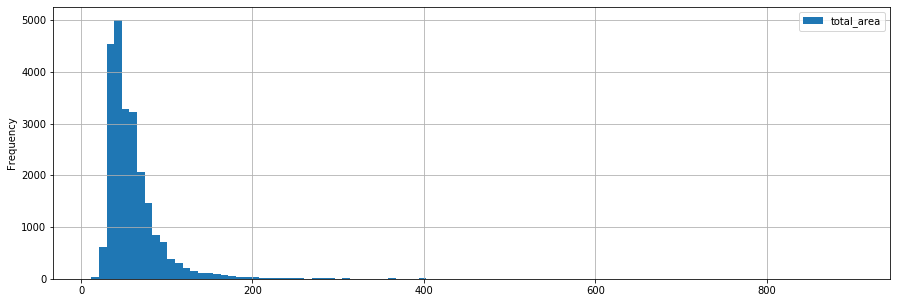

In [37]:
df.plot(kind = 'hist', y = 'total_area', bins = 100, grid = True, figsize = (15,5))

Пик значений в районе 70, резкий спад после 100 и почти у 0 значений после 200.

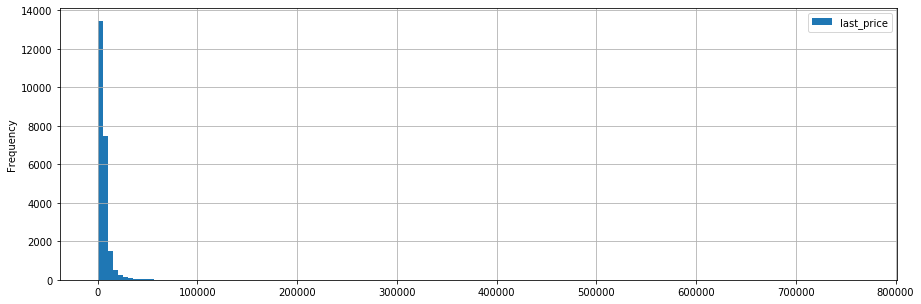

In [38]:
df.plot(kind = 'hist', y = 'last_price', bins = 150, grid = True, figsize = (15,5))

Здесь наблюдается пик в райне низких цен (около 0), а после 20000 значения стремяться к 0. Можно сделать вывод, что есть выбросы на огромные суммы.

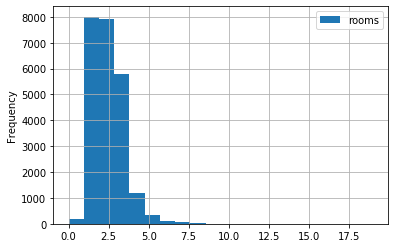

In [39]:
df.plot(kind = 'hist', y = 'rooms', bins = 20, grid = True)

В среднем квартиры состоят из 2 и 3 комнат, а квартир, где больше 5 встречается очень мало.

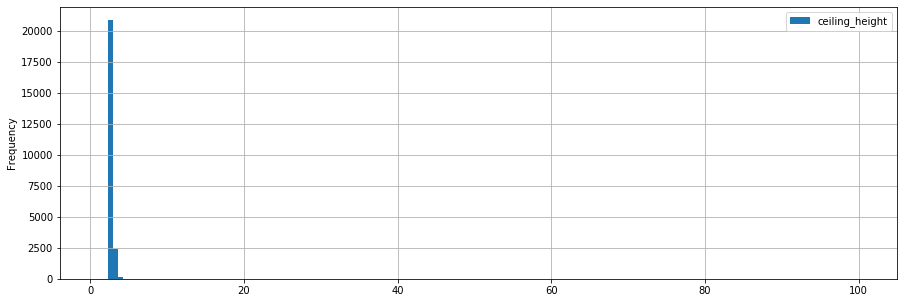

In [40]:
df.plot(kind = 'hist', y = 'ceiling_height', bins = 150, grid = True, figsize = (15,5))

По этому графигу можно сказать, что потолки для большинства квартир одной высоты. Такой разброс говорит и выбросах в данных. Учтем это в дальших исследованиях. 

### Вывод

1. Больше всего продается квартир площадью в диапозоне от 50 до 100 кв.м.
2. Есть квартиры с огромными стоимостями, которые встречаются очень редко.
3. Больше всего встречается квартир с одной и двумя комнатами, а более пяти крайне редко.
4. Высота потолков в большинстве случаев попадает под стандарты. Если потолки выше, то это либо нетичный случай, либо выброс в данных.

Учтем гистограммы, когда будем чистить данные. Они помогут принять нас правильное решение.

### Исследование время продажи квартиры. <a id="timesell"></a>

Построим гистограмму методом plot() для столбца days_exposition.

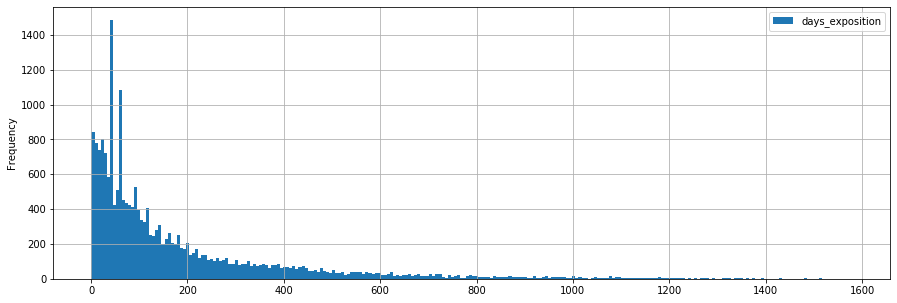

In [41]:
df.plot(kind = 'hist', y = 'days_exposition', bins = 250, grid = True, figsize = (15,5))

Можно сделать вывод, что время на продажу убывает, что логично. Но есть те, которые продаются очень долго, особенно после 800 дней, количество таких продаж стремиться к 0. Так же есть сверх быстрые продажи, что тоже довольно странно. И присутствует два значения, которые явно выбиваются. Это может быть связанно с тем, что алгоритм программы закрывает объявления о продаже автоматически.

Вызовем метод describe, чтобы найти среднее и медиану.

In [42]:
df['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

### Вывод

Среднее: 180.7, медиана: 95.0. 

Значит, что средняя продажа квартиры находится в этих двух числах, то есть примерно квартира продается от 3 до 6 месяцев.

Стоит отметить, что минимальное время продажи - 1 день, что очень нереалистично. Учтем это в дальнейших исследованиях.

Так же можно сказать, что те значения, которые за пределами первого квантиля, то есть до 45 дней - довольно быстрые продажи. А те, которые за пределами третьего - долгие.

Получается, продажи до полутора месяца - быстрые, более восьми месяцев - долгие продажи. 

### Ликвидация редких и выбивающихся значений. <a id="rare"></a>

Давайте исключим их данных редкие, нереалистичные и выбивающиеся значения. По столбцам total_area, last_price, rooms, ceiling_height и days_exposition состовим графики боксплот, что может нам определиться со срезами. Затем сохраним все значения, которые нам подходят, в переменной good_data.

Начнем со столбца total_area. Построим график.

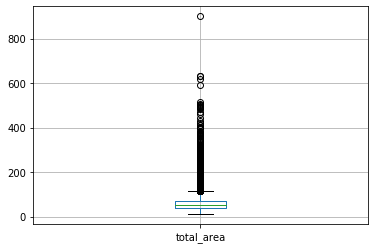

In [43]:
df.boxplot('total_area')


Сразу можно сделать вывод, что значения после 130-140 не самые частые. Давайте посторим график заново, но ограничим его до 200 кв.м.

(0, 200)

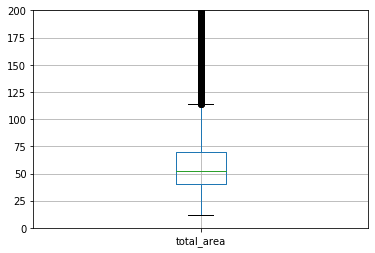

In [44]:
df.boxplot('total_area')
plt.ylim(0,200)

Как мы видим, квартиры более 115 кв.м. встречаются все реже и реже. Это подтверждается гистограммой, которую мы сделали выше.

Посмотрим на столбец last_price. Построим график, но учтем гистограмму сделанную раннее, поэтому поставим ограничение до 20000 тыс.

(0, 20000)

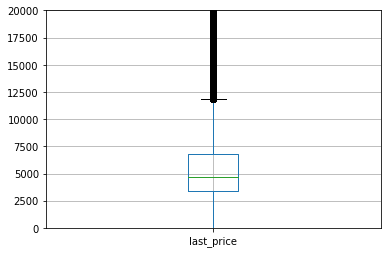

In [45]:
df.boxplot('last_price')
plt.ylim(0,20000)

Значения, которые после 12000 встречаются уже все реже.
Стоит отметить, что подозрительно маленькие значения входят в хвосты графика. Давайте посмотрим на минимальную стоимость квартиры. Вызовим метод describe.

In [46]:
df['last_price'].describe()

count     23565.000000
mean       6540.042987
std       10910.929793
min          12.000000
25%        3400.000000
50%        4646.000000
75%        6790.000000
max      763000.000000
Name: last_price, dtype: float64

Действительно, минимальная стоимость за жилье всего лишь 12 тыс. Это выглядит нереалистично, даже если это очень маленькая квартира.
Давайте найдем границу значений, которые соответсвуют 5ой перцентили.

In [47]:
df['last_price'].quantile(0.05)

1860.0

1860 - уже выглядит реалистичнее. Будем ориентироваться на эту цифру, когда сделаем срез.

Строим боксплот для данных по комнатам. Ограничим границы графика значениями до 10, ориентируясь на гистограмму.

(0, 10)

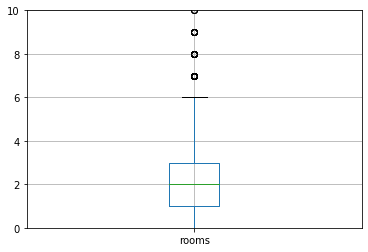

In [48]:
df.boxplot('rooms')
plt.ylim(0,10)

Квартиры, где комнат больше 6 встречается все реже.

Аналогично как с гистограммой по столбцу rooms, анализируем по гистограмме и оставляем границы до 6.

(0, 5)

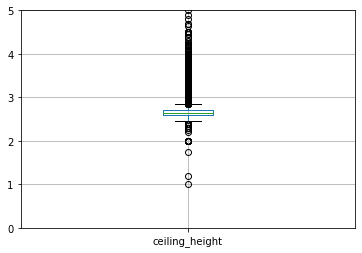

In [49]:
df.boxplot('ceiling_height')
plt.ylim(0,5)

Основная масса значений находится на уровне чуть более 2.5 метра. Давайте найдем 1ый и 99й перцентили, чтобы определить границы размаха.

In [50]:
df['ceiling_height'].quantile(0.01)

2.5

In [51]:
df['ceiling_height'].quantile(0.99)

3.6

2.5 и 3.6 - это и будут границы нашего среза по высоте потолков.

Построим график по столбцу days_exposition. Учитывая гистограмму, ограничим до 800 значений.

(0, 800)

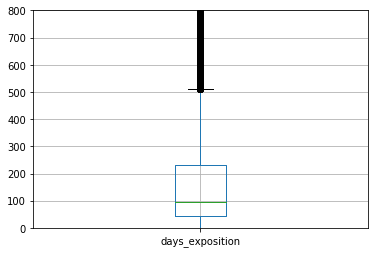

In [52]:
df.boxplot('days_exposition')
plt.ylim(0,800)

Аналогично столбу last_price, найдем 5 перцентиль и по ней уже составим срез для этого столбца.

In [53]:
df['days_exposition'].quantile(0.05)

9.0

9 дней. Все еще маловероятно, но намного реалистичнее, чем 1.
Хоть и граница третьего квартиля около 500 дней, давайте не будем убирать эти значения. Да, это нетипичная ситуация, но в дальнейших исследованиях нам нужны данные по годам, а ограничение в 500 дней это всего лишь 1.5 года.

### Вывод

Проанализовав столбцы total_area, last_price, rooms, ceiling_height и days_exposition по гистограмме и боксплоту, можно сказать следующее:
- в срез по столбцу total_area попадают значения до 150 кв.м.
- в срез по столбцу last_price попадают значения от 1860 тыс. до 15000 тыс. (хоть и боксплот показал границы в районе 12000, но много значений имеется до 15000. Это могут быть квартиры, например с 5-6 комнатами).
- в срез по столбцу rooms попадают значения до 6 комнат включительно.
- в срез по столбцу ceiling_height попадают значения от 2.5м до 3.6м.
- в срез по столбцу days_exposition попадают значения от 9.

Заведем переменную good_data с "чистыми" данными.

In [54]:
good_data = df.query(('total_area <= 150 and 1860 <=last_price < 20000 and rooms <= 6 and 2.4 <= ceiling_height <= 3 and 9 <= days_exposition'))

Давайте посмотрим, как изменились наши данные. Сравним количество строк в сыром и чистом датафрейме.

In [55]:
len(df)

23565

In [56]:
len(good_data)

16940

Около трети данных выброшены. Но зато у нас выборка с самыми типичными случаями.

### Исследование факторов, которые больше всего влияют на стоимость. <a id="cost"></a>

На этом этапе мы будем искать зависимость различных факторов на стоимость квартиры. Рассматривать будем как влияет площадь, числло комнат и удаленности от центра, есть ли зависимость от типа этажа и даты размещения.

Прежде чем начать искать зависимость цены от площади, давайте огрулим значения чисел (для удобства отображения закономерности). Сделаем новый столбец area_10 и по нему дальше будем строить график.

In [57]:
good_data['area_10'] = good_data['total_area'] // 10 * 10

Сгруппируем в переменную total_area_dep по area_10 медианы столбца last_price.
Сделаем график.

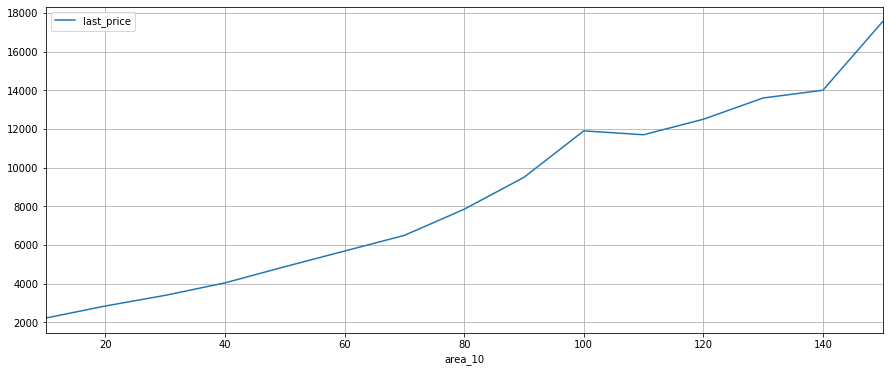

In [58]:
total_area_dep = good_data.groupby('area_10').agg({'last_price':'median'})
total_area_dep.plot(figsize=(15, 6), grid=True)

Линейной зависимостm наблюдается. Чтобы убедиться, дfвайте посмотрим на коэффициент корреляции.

In [59]:
good_data['area_10'].corr(good_data['last_price'])

0.7487522367455073

Модульное значение коэффициента стремиться к единице. Засимость от общей площади наблюдается.

Далее сгруппируем в переменную rooms_dep по столбцу rooms медианы столбца last_price. Выведем график.

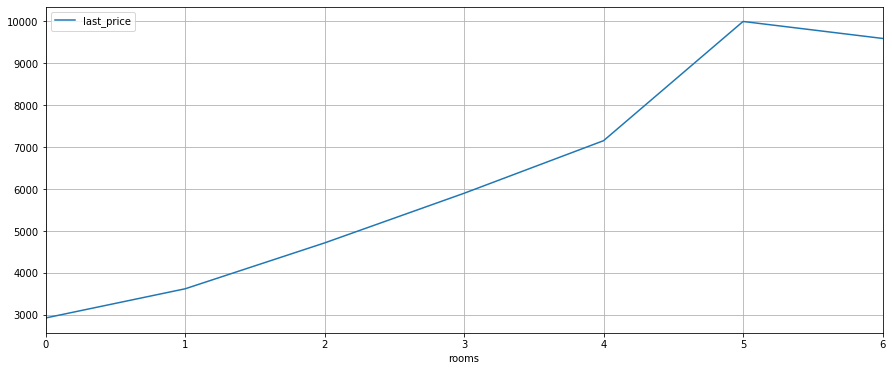

In [60]:
rooms_dep = good_data.groupby('rooms').agg({'last_price':'median'})
rooms_dep.plot(figsize=(15, 6), grid=True)

Линейная зависимость наблюдается. Чем больше комнат, тем дороже стоимость квартиры.
Выведем коэффициент корреляции.

In [61]:
good_data['rooms'].corr(good_data['last_price'])

0.47567298968557625

Да, небольшая корреляция есть.

Проверим зависимость цены за кв.м. от площади.

Сгруппируем медианы цен за квадрат по столбцу area_10. Посмоторим график и выведем его

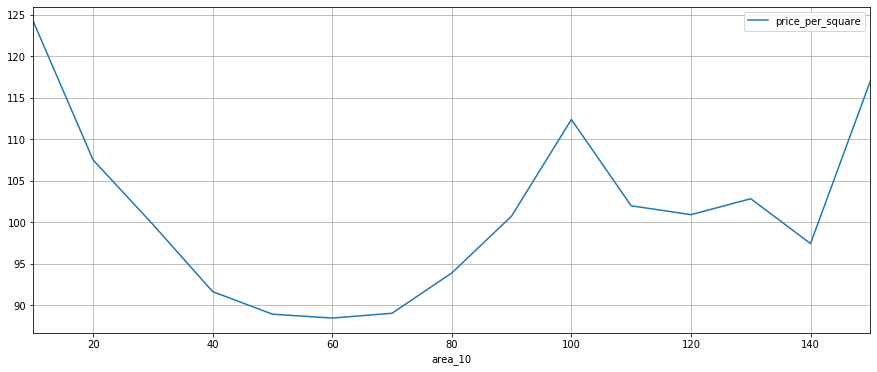

In [62]:
total_area_dep_square = good_data.groupby('area_10').agg({'price_per_square':'median'})
total_area_dep_square.plot(figsize=(15, 6), grid=True)

Четкой зависимости не наблюдается. Посмотрим коэффициент корреляции для уверенности.

In [63]:
good_data['area_10'].corr(good_data['price_per_square'])

-0.01452690098813154

Да, так и есть, корреляции можно считать нет.

Стоит отметить, что в начале график стремиться вниз, что говорит о том, что от роста площади падала цена за жилье, затем на уровне 70 кв.м. начинает рости. Скорее всего это связано с тем, что большие квартиры строят в домах выше классом, которые могут позволить себе более обеспеченные люди, из-за чего стоимость за квадратный метр растет, но незначительно.
Предположу, что в соотношении площадь/цена за квадрат, самой выгодной покупкой можно считать квартиры от 50 до 80 кв.м.

Проверим, есть ли зависимость стоимости кв.м. от количества комнат.

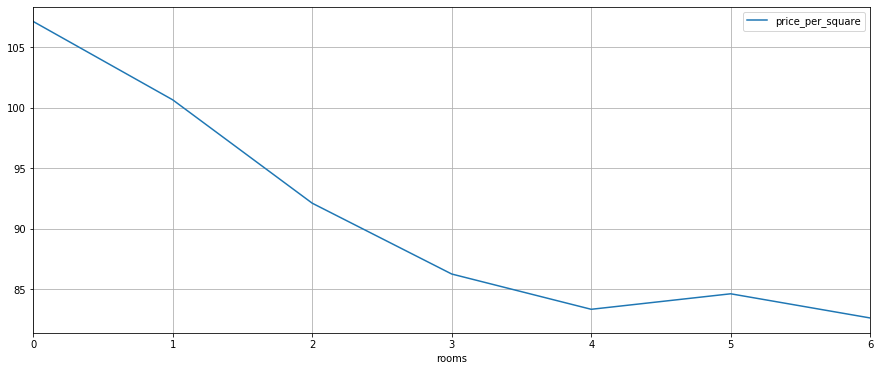

In [64]:
rooms_dep_square = good_data.groupby('rooms').agg({'price_per_square':'median'})
rooms_dep_square.plot(figsize=(15, 6), grid=True)

Линейная зависимость присутствует. Чем больше комнат, тем меньше стоимость за кв.м.

Найдем зависимость цены от расстояния к центру. Для более удобной демонстрации округлим данные до 1 км и выведем в новый столбец 

In [65]:
good_data['to_city_km'] = good_data['cityCenters_nearest'] // 1000 * 1000

Сгруппируем в переменную city_center_dep по to_city_km медианы столбца last_price. Сделаем график.

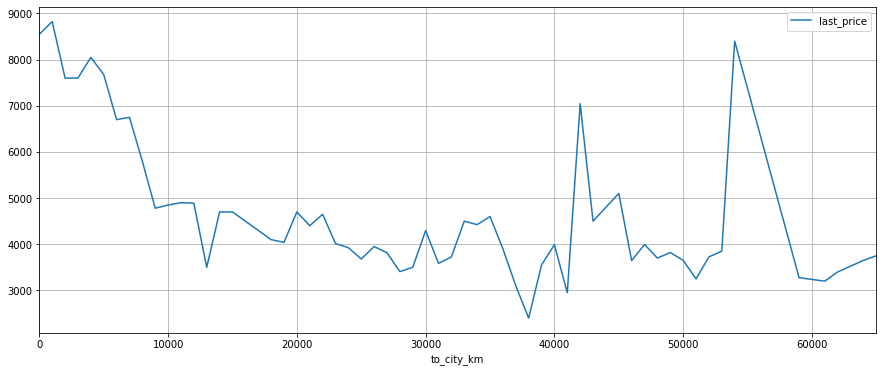

In [66]:
city_center_dep = good_data.groupby('to_city_km').agg({'last_price':'median'})
city_center_dep.plot(figsize=(15, 6), grid=True)

Явной зависимости не наблюдается, но можно предположить, что высокие значения на большем расстоянии от центра это единичные случаи. Давайте выведем коэффициент корреляции.

In [67]:
good_data['to_city_km'].corr(good_data['last_price'])

-0.2717789391139574

Действительно, корреляция есть, но очень незначительная. Чем дальше от центра - тем дешевле стоимость квартиры.

Чтобы найти зависимость от этажа, сгуппируем медианы столбца price_per_square по столбцу floor_type.
Выведем график.

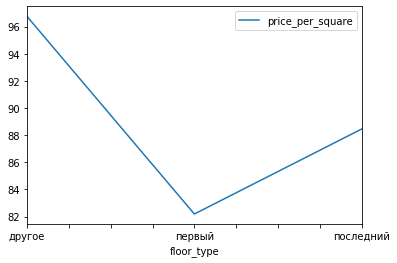

In [68]:
floor_dep = good_data.groupby('floor_type').agg({'price_per_square':'median'})
floor_dep.plot()

Наблюдается нелинейная зависимость. Квартиры на крайних этаж стоят дешевле. Это диктуется спросом на соотвествующие квартиры, так как люди сомневаются приобретать такое жилье. Крайние этажи несут за собой проблемы: крыша \ подвал, шум шахты лифта \ любопытные прохожие \ подвальный этаж занят под магазин и прочее

Далее найдем зависмость цены от дня недели, месяца и года. Сгруппируем медианы price_per_square по соответствующи столбцам (weekday, month, year). 
Выведем графики на экран.

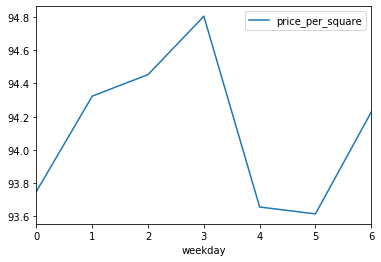

In [69]:
weekday_dep = good_data.groupby('weekday').agg({'price_per_square':'median'})
weekday_dep.plot()

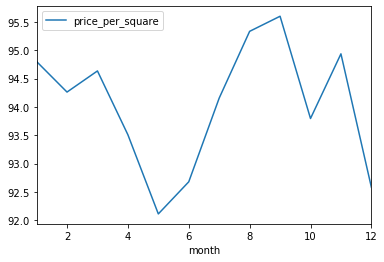

In [70]:
month_dep = good_data.groupby('month').agg({'price_per_square':'median'})
month_dep.plot()

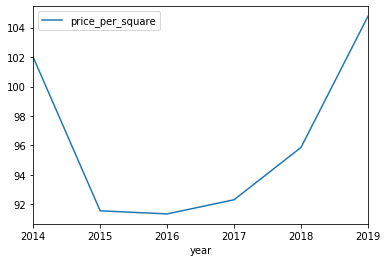

In [71]:
year_dep = good_data.groupby('year').agg({'price_per_square':'median'})
year_dep.plot()

Линейной зависимости не наблюдается ни по одному из графиков. 
На графике зависимости по дням недели мы видим, что объявления выставленные в пятницу и субботу имеют стоимость ниже.
График по месяцам дает понять, что в 5 месяце квартиры стоят дешевле, в 9 дороже всего.
График зависимости по году показывает, что с 2014 был спад в стоимости, затем с 2016 рост цен.
Сложно выявить явную  зависимость, но предположу, что такие значения в графике по годам связаны с падением рубля с 2014 до 2016 и последующим долгим укреплением до 2019.

### Вывод

Выявленные факторы, которые явно влияют на стоимость квартиры - площадь квартиры и количество комнат.

Менее явный фактор - расстояние до центра.

Отсутствие зависимости у таких факторов как этаж и время выставления объявления.

### Исследование 10 населенных пунктов с наибольшим числом объявлений. <a id="top10"></a>

Для нахождения 10 населенных пунктов с наибольшим числом объявлений, создадим переменную top_10_local. Сгруппируем столбец с названиями и посчитаем их количество в таблице. Затем отсортируем, выведем первые 10 значений, после чего переобразуем данные в список.

In [72]:
top_10_local = good_data.groupby('locality_name')['locality_name'].count().sort_values(ascending = False).head(10).index.tolist()

top_10_local

['Санкт-Петербург',
 'посёлок Мурино',
 'посёлок Шушары',
 'Всеволожск',
 'деревня Кудрово',
 'Колпино',
 'посёлок Парголово',
 'Пушкин',
 'Гатчина',
 'Петергоф']

Отлично, вот наши населенные пункты.

Теперь, выведем новую переменную good_locals, в которую будут входить только города из списка top_10_local. Сразу сгруппирем но названию локации и выведем среднее за квадратный метр, макисмум и минимум стоимости квартиры.

In [73]:
good_locals = good_data.query('locality_name in @top_10_local').groupby('locality_name').agg({'price_per_square':'mean', 'last_price':['max', 'min']})

Теперь давайте выведем нашу таблицу и посмотрим искомые значения. Отсортируем ее по средней стоимости за кв.м.

In [74]:
good_locals.sort_values(by = ('price_per_square','mean'), ascending = False)

price_per_square last_price      
                              mean        max   min
locality_name                                      
Санкт-Петербург         106.477023      19999  1870
Пушкин                  100.114990      16912  1990
деревня Кудрово          92.288609      13000  2100
посёлок Парголово        89.505949       9140  1938
посёлок Мурино           86.087750       8500  1870
Петергоф                 82.508144      12000  2100
посёлок Шушары           77.992024      10700  2000
Колпино                  74.769652      12750  2100
Гатчина                  68.981024      12700  1880
Всеволожск               67.502098      10890  1900

Как мы видим, самый дорогой квадратный метр в Санкт - Петербурге.

Посмотрим на самые дорогие квартиры. Отсортируем по максимальной стоимости

In [75]:
good_locals.sort_values(by = ('last_price','max'), ascending = False)

price_per_square last_price      
                              mean        max   min
locality_name                                      
Санкт-Петербург         106.477023      19999  1870
Пушкин                  100.114990      16912  1990
деревня Кудрово          92.288609      13000  2100
Колпино                  74.769652      12750  2100
Гатчина                  68.981024      12700  1880
Петергоф                 82.508144      12000  2100
Всеволожск               67.502098      10890  1900
посёлок Шушары           77.992024      10700  2000
посёлок Парголово        89.505949       9140  1938
посёлок Мурино           86.087750       8500  1870

Ситуация та же, у нас самая дорогая квартира в Санкт-Петербурге.

Взглям на минимальные стоимости квартир.

In [76]:
good_locals.sort_values(by = ('last_price','min'))

price_per_square last_price      
                              mean        max   min
locality_name                                      
Санкт-Петербург         106.477023      19999  1870
посёлок Мурино           86.087750       8500  1870
Гатчина                  68.981024      12700  1880
Всеволожск               67.502098      10890  1900
посёлок Парголово        89.505949       9140  1938
Пушкин                  100.114990      16912  1990
посёлок Шушары           77.992024      10700  2000
Колпино                  74.769652      12750  2100
Петергоф                 82.508144      12000  2100
деревня Кудрово          92.288609      13000  2100

Сразу два населенных пункта с минимальной стоимостью жилья: Санкт-Петербург и поселок Мурино.

### Вывод

Можно сказать, что Санкт-Петербург предлагает самый широкий выбор квартир. Как дорогих, так и доступных.

### Исследование предложения квартир в Санкт-Петербурге по степени удаленности от центра. <a id="spb"></a>

На данном этапе мы будем искать центральную область для Санкт-Петербурга.

Создадим срез данных только по Санкт-Петербургу.

In [77]:
spb_data = good_data.query('locality_name == "Санкт-Петербург"')

У нас уже есть округленный столбец to_city_km до 1000 метров. Поделим его на 1000, чтобы остались только километры.

In [78]:
spb_data['to_spb_km']=spb_data['to_city_km']/1000

Посчитаем среднюю стоимость каждого километра. Сделаем таблицу mean_km с медианами цен по расстоянию от центра.ц

In [79]:
mean_km = spb_data.pivot_table(index = 'to_spb_km', values = 'last_price', aggfunc = 'median')
mean_km

last_price
to_spb_km            
0.0            8550.0
1.0            8825.0
2.0            7600.0
3.0            7600.0
4.0            8050.0
5.0            7678.0
6.0            6700.0
7.0            6750.0
8.0            5800.0
9.0            4780.0
10.0           4850.0
11.0           4900.0
12.0           4890.0
13.0           5090.0
14.0           4700.0
15.0           4700.0
16.0           4500.0
17.0           4369.0
18.0           4215.0
19.0           4300.0
20.0           5700.0
21.0           4600.0
22.0           4774.5
23.0           4100.0
24.0           3480.0
25.0           3499.0
26.0           3375.0
27.0           2250.0
28.0           4775.0

Пока сложно сделать точные выводы. Для наглядности построим график.

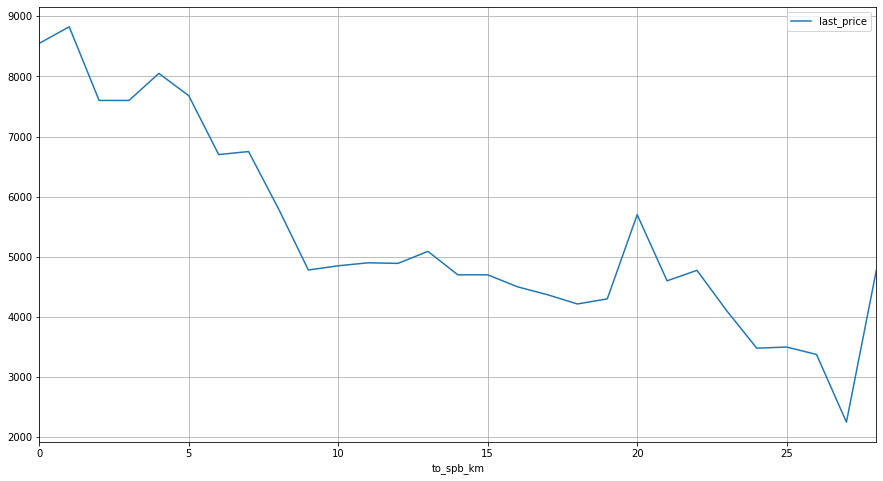

In [80]:
mean_km.plot(grid=True, figsize=(15, 8))

Теперь мы видим тенденцию. С 7 километра график убавляется, а после 9 километра выравнивается. 

### Вывод

Центром Санкт-Петербурга можно считать зону, которая имеет радиус 7 км.

### Сравнение квартир в центре и по всему городу <a id="city"></a>

Выделим в переменную spb_centre срез с ограничением до 7 км включительно. Выведем первые 10 строк.

In [81]:
spb_centre = spb_data.query('to_spb_km <= 7')
spb_centre.head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
24              8        6500        97.2           2015-10-31      2   
35              6       15500       149.0           2017-06-26      5   
61             18        7990        74.0           2017-08-24      2   
99             32        9600        90.0           2017-09-26      4   
111             4        4590        40.0           2017-05-29      1   
137            11       13310        85.1           2018-01-01      2   
138             8        4800        40.0           2017-11-18      2   
143             9        2990        30.0           2016-06-08      1   
145             6        8290        77.0           2015-09-21      2   
159            14        7050        66.0           2017-09-04      3   

     ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
24             2.65           3.0        46.50      1         False  ...   
35             2.65           5.0       104.00      4         False  ...   
61             2.65           4.0        43.00      4         False  ...   
99             2.65           5.0        67.00      2         False  ...   
111            2.65           6.0        18.00      1         False  ...   
137            2.70          10.0        31.52      5         False  ...   
138            2.65           3.0        29.00      2         False  ...   
143            2.50           9.0        20.00      9         False  ...   
145            2.77          16.0        40.00      5         False  ...   
159            3.00           4.0        37.80      4         False  ...   

     price_per_square  weekday  month  year floor_type  corr_living  \
24          66.872428        5     10  2015     первый     0.478395   
35         104.026846        0      6  2017     другое     0.697987   
61         107.972973        3      8  2017  последний     0.581081   
99         106.666667        1      9  2017     другое     0.744444   
111        114.750000        0      5  2017     первый     0.450000   
137        156.404230        0      1  2018     другое     0.370388   
138        120.000000        5     11  2017     другое     0.725000   
143         99.666667        2      6  2016  последний     0.666667   
145        107.662338        0      9  2015     другое     0.519481   
159        106.818182        0      9  2017  последний     0.572727   

     corr_kitchen  area_10  to_city_km  to_spb_km  
24       0.201646     90.0        2000        2.0  
35       0.114094    140.0        3000        3.0  
61       0.270270     70.0        4000        4.0  
99       0.088889     90.0        2000        2.0  
111      0.250000     40.0        6000        6.0  
137      0.315511     80.0        4000        4.0  
138      0.150000     40.0        2000        2.0  
143      0.186667     30.0        6000        6.0  
145      0.129870     70.0        7000        7.0  
159      0.166667     60.0        4000        4.0  

[10 rows x 32 columns]

Для сравнения центра и города постороим графики, на которых будут изображена зависимость площади, числа комнат и высота потолков от стоимости квартиры.
Для этого выделим столбцы area_10, ceiling_height, rooms в отдельный список. Затем составим цикл, в котором будем использовать данные столбцы, чтобы построить графики. И по ним уже будем анализировать.

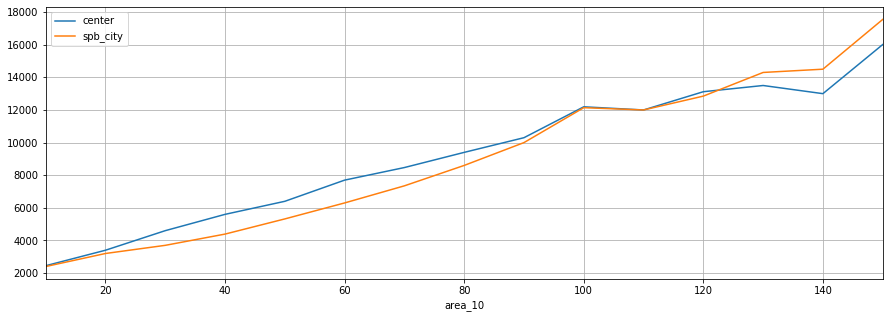

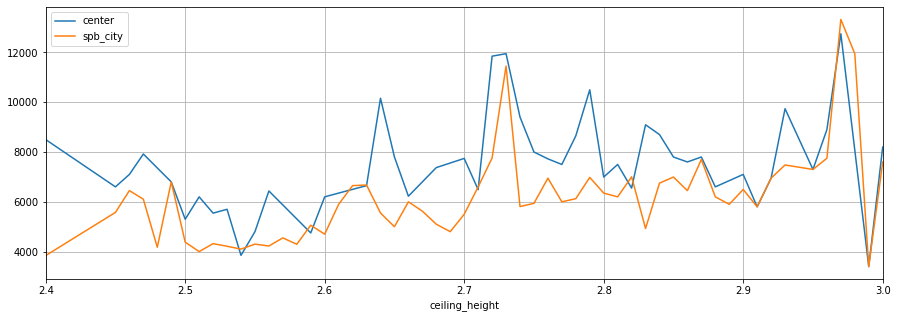

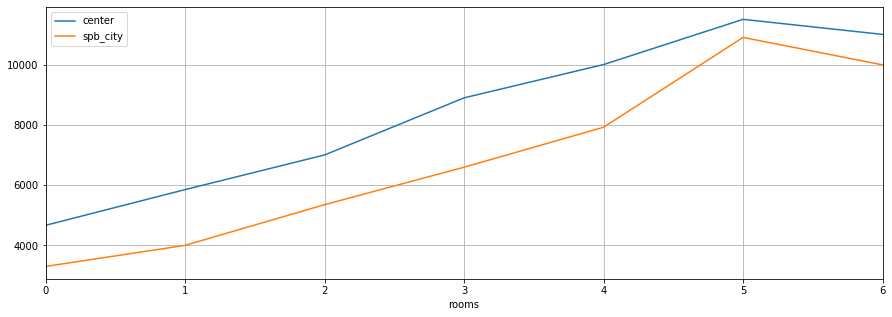

In [82]:
columns = ['area_10', 'ceiling_height', 'rooms']
for column in columns:
    ax = spb_centre.groupby(column)['last_price'].median().plot(figsize=(15, 5), grid=True, label='center', legend = True)
    spb_data.groupby(column)['last_price'].median().plot(figsize=(15, 5), grid=True, ax = ax, label='spb_city', legend = True)
    plt.show()

### Вывод:

1. Зависимость от площади что в центре, что по всему городу линейная. Графики почти идентичные, можно сделать вывод, что где бы не находилась квартира, площадь в равной степени влияет на стоимость квартиры.

2. Цены от высоты потолков в центре немного выше цен за те же высоты по всему городу. Линия center находится над линией spb_city на протяжении всего графика. Делаем вывод, что высота потолков не так влияет на стоимость квартиры, здесь определяюшим является именно приближенность к центру.

3. Аналогично с предыдущим графиком, линия center выше линии spb_center на протяжении всего графика. Значит, что чем ближе к центру, тем дороже квартира.

Проанализируем следующие факторы, которые могут влиять на стоимость квартиры. А иммено это этаж и срок размещения объявления.
Для этого выделим столбцы floor, first_day_exposition в отдельный список. Затем составим цикл, в котором будем использовать данные столбцы, чтобы построить графики. На этот раз возьмем цену за квадратный метр.

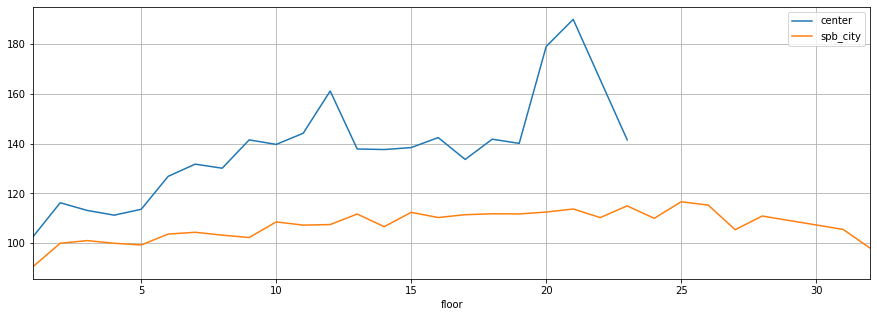

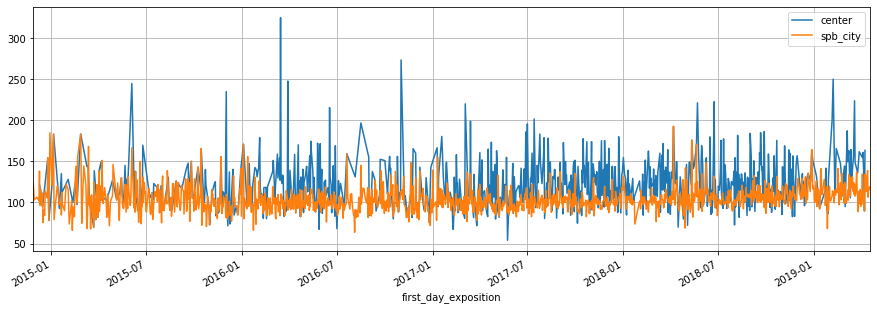

In [83]:
columns = ['floor', 'first_day_exposition']
for column in columns:
    ax = spb_centre.groupby(column)['price_per_square'].median().plot(figsize=(15, 5), grid=True, label='center', legend = True)
    spb_data.groupby(column)['price_per_square'].median().plot(figsize=(15, 5), grid=True, ax = ax, label='spb_city', legend = True)
    plt.show()

### Вывод:

1. Зависимости прямой по этажам нет. График center лежит выше графика spb_city, это значит, что квартиры в центре в среднем дороже квартир по всего городу. Стоит отметить, что график center обрывается на значении 23, это говорит о том, что ближе к окраинам дома строят выше.
2. Зависимости по сроку объявлений тоже не наблюдается. Квартиры в центре продаются так же долго как и квартиры в другой части города. Сложно сказать, что со времнем цена на жилье как-то менялась.

Добавим новый столбец type_center, в котором категоризиуем данные.

In [84]:
spb_data['type_center']= spb_data.loc[spb_data['to_spb_km'] <= 7, 'type_center']='сenter'
spb_data.loc[spb_data['to_spb_km'] > 7, 'type_center']='outside_center'

Построим гистограммы и сравним квартиры в центре и за его пределами. Возьмем параметры area_10, last_price, ceiling_height, rooms

In [85]:
columns = ['area_10', 'last_price','ceiling_height', 'rooms']
for column in columns:
    fig = px.histogram(spb_data, x = column, color = 'type_center', marginal = 'box',
                  title = column)
    fig.show()

### Выводы по гистограммам:

- Квартиры в центре чуть больше квартир за его пределами, если обратить внимание на график распределение, он смещен вправо.
- Стоимость квартир в центре выше, так же анализируя боксплот.
- Высота потолков в среднем в центре чуть выше, это заметно по тому, что красные блоки выше на протящении всего графика. Так же  если заметить, то боксплот квартир в центре тянется в правую сторону, а квартир за пределами центра в левую.
- В центре больше минимум двухкомнатных квартир. Это видно по первому квартилю. У квартир вне центра 1 первый квартиль на уровне 1 комнаты. У квартир в центре, первый квартиль на одному уровне с медианой, а 3 квартиль заканчивается на уровне 3 комнат.

Посмотрим как стоимость зависила от времени.

Построим графики распределения, по столбцам days_exposition и first_day_exposition.

In [86]:
fig = px.scatter(spb_data, x = 'last_price', y = 'days_exposition', color = 'type_center', trendline="ols")
fig.show()

In [87]:
fig = px.scatter(spb_data, y = 'last_price', x = 'first_day_exposition', color = 'type_center')
fig.show()

### Выводы:

1. Смотря на линии тендении, можно сделать вывод, что квартиры в центре в среднем дороже квартир за его пределами
2. Так же можно сказать, смотря на первый график, что чем дороже квартира, тем чуть дольше она продается. Это справедливо для оба типа квартир. Квартиры в центре продаются чуть дольше остальных квартир.
3. По второму графику можно сказать, что есть периоды, когда одни квартиры продавались лучше других.

Выведем таблицу, где посмотрим как коорелируют между собой различные параметры. Сравним центр и остальной город.

In [88]:
columns = ['total_area', 'rooms', 'ceiling_height', 'price_per_square', 'to_spb_km']
for column in columns:
    spb_corr = spb_data.pivot_table(index = 'type_center', values = ['last_price', column], aggfunc = 'corr')
    display(spb_corr)

last_price  total_area
type_center                                      
outside_center last_price    1.000000    0.834119
               total_area    0.834119    1.000000
сenter         last_price    1.000000    0.718745
               total_area    0.718745    1.000000

last_price     rooms
type_center                                    
outside_center last_price    1.000000  0.510199
               rooms         0.510199  1.000000
сenter         last_price    1.000000  0.455085
               rooms         0.455085  1.000000

ceiling_height  last_price
type_center                                              
outside_center last_price            0.350658    1.000000
               ceiling_height        1.000000    0.350658
сenter         last_price            0.124803    1.000000
               ceiling_height        1.000000    0.124803

last_price  price_per_square
type_center                                                  
outside_center last_price          1.000000          0.474343
               price_per_square    0.474343          1.000000
сenter         last_price          1.000000          0.464868
               price_per_square    0.464868          1.000000

last_price  to_spb_km
type_center                                     
outside_center last_price    1.000000  -0.143895
               to_spb_km    -0.143895   1.000000
сenter         last_price    1.000000  -0.087310
               to_spb_km    -0.087310   1.000000

Сравнив коэффициенты, можно сказать, что в целом параметры квартир за центром сильнее коррелируют со стоимостю.  Коэффециенты корреляции квартир в центре, ниже коэффициентов остальных квартир.

Вспоминая предыдущие графики, можно сказать, что это связанно с лучшими условиями жилья в центре в целом. Поэтому чем, лучше квартира за пределами центра - тем сильнее видна зависимость от различных параметров.

Посмотрим на зависимость стоимости от этажа. Построим график, посмотрим, есть ли различия.

In [89]:
fig = px.line(spb_data.pivot_table(index = ['floor_type','type_center'], values = 'price_per_square', aggfunc = 'median').reset_index(), x = 'floor_type', y = 'price_per_square', color = 'type_center',
                  title = 'Зависимость от типа этажа')
fig.show()

По графику можно сказать, что в целом квадратный метр в центре дороже, но тенденция та же, что в остальном городе. Люди менее охотно покупают квартиры на крайних этажах.

### Шаг 5. Общий вывод <a id="conclusion"></a>

Задача этого исследования была установить параметры, которые влияют на стоимость квартиры. 

Факторы, которые в первую очередь стоит отметить:
- площадь жилья
- количество комнат
- удаленность от центра

Факторы, которые мало влияют, либо совсем не влияют:
- этаж, на котором рассполагается квартира
- время размещения объявления о продажи
- срок размещения объявления

Чтобы придти к этому решению, мы предобработали данные, добавили нужные нам параметры, исследовали различные показатели, сделали срез типичных случаев и убрали нетипичные, сравнивали различные населенные пункты, искали закономерности в одном населенном пункте.